# ATNLP 2020 - University of Copenhagen
Final project consisting of group reimplementation of Lake and Baroni 2018 and an additional model which aims to improve on the results of the classical seq2seq RNNs.



## 1. Instantiate necessary packages

In [1]:

import torch
import torch.utils.data
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset,DataLoader
from torch import Tensor

from typing import List, Tuple
import re
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math
plt.switch_backend('agg')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

MAX_LENGTH=48
teacher_forcing_ratio = 0.5
clip = 5

Mounted at /content/drive


## 2. Load data

In [2]:
class SCANdata(Dataset):

    # Initialize and clean data
    def __init__(self,data):
      self.commands = data['In']   
      self.actions = data['Out']     
      self.len = len(data['In'] )
    
    def __getitem__(self, index):
        #important: we add an extra item to our tensors which is a [1]. In both cases, a [1] represent an EOS token
        return torch.cat((Tensor(self.commands[index]), Tensor([1]) ),0).view(-1,1), torch.cat((Tensor(self.actions[index]), Tensor([1])),0).view(-1,1)
        
    def __len__(self):
        return self.len

In [3]:
    # Initialize and clean data
    def load_data(data):
        colnames = ["In","Out"]
        data = pd.read_csv(data,sep="OUT:",header = None,names=colnames, engine='python')
        data['In'] = data['In'].apply(lambda x: re.sub('IN:','', str(x)))
        data['In'] = data['In'].apply(lambda x : x.split())
        data['Out'] = data['Out'].apply(lambda x : x.split())
        return data


In [4]:
# for experiment no 1 - simple split and size variations (sv)
simple_train_path = "/SCAN/simple_split/tasks_train_simple.txt"
simple_test_path = "/SCAN/simple_split/tasks_test_simple.txt"

percent_of_commands = 1
simple_train_path_sv = f"/SCAN/simple_split/size_variations/tasks_train_simple_p{str(percent_of_commands)}.txt"
simple_test_path_sv = f"/SCAN/simple_split/size_variations/tasks_test_simple_p{str(percent_of_commands)}.txt"


#for experiment no 2

length_train_path = "/SCAN/length_split/tasks_train_length.txt"
length_test_path = "/SCAN/length_split/tasks_test_length.txt"

#for experiment no 3
lturn_train_path = "/SCAN/add_prim_split/tasks_train_addprim_turn_left.txt"
lturn_test_path = "/SCAN/add_prim_split/tasks_test_addprim_turn_left.txt"
jump_train_path = "/SCAN/add_prim_split/tasks_train_addprim_jump.txt"
jump_test_path = "/SCAN/add_prim_split/tasks_test_addprim_jump.txt"

#for exp no 3 jump composed
def get_path(num, rep, traintest= 'train'):
    path = f"/SCAN/add_prim_split/with_additional_examples/tasks_{traintest}_addprim_complex_jump_{num}_{rep}.txt"
    return path

num,rep = 'num32','rep4'
train_composed_jump = get_path(num=num,rep=rep)
test_composed_jump = get_path(num=num,rep=rep,traintest = 'test')

#load the data from the path into variable
train_data = load_data(jump_train_path)
test_data = load_data(jump_test_path)

train_data

,In,Out
0,[jump],[I_JUMP]
1,"[look, opposite, right, thrice, and, walk, left]","[I_TURN_RIGHT, I_TURN_RIGHT, I_LOOK, I_TURN_RI..."
2,"[run, after, run, left]","[I_TURN_LEFT, I_RUN, I_RUN]"
3,"[run, twice, and, look, left, thrice]","[I_RUN, I_RUN, I_TURN_LEFT, I_LOOK, I_TURN_LEF..."
4,"[run, opposite, left, twice, and, turn, opposi...","[I_TURN_LEFT, I_TURN_LEFT, I_RUN, I_TURN_LEFT,..."
...,...,...
14665,"[look, around, left, and, walk, around, left]","[I_TURN_LEFT, I_LOOK, I_TURN_LEFT, I_LOOK, I_T..."
14666,"[run, opposite, right, thrice, after, run, opp...","[I_TURN_LEFT, I_TURN_LEFT, I_RUN, I_TURN_LEFT,..."
14667,"[turn, around, right, and, run, right, thrice]","[I_TURN_RIGHT, I_TURN_RIGHT, I_TURN_RIGHT, I_T..."
14668,"[walk, around, left, thrice, after, turn, right]","[I_TURN_RIGHT, I_TURN_LEFT, I_WALK, I_TURN_LEF..."


In [5]:
commands = set()
actions = set()

# Add all our words into a set for getting unique ones
for sent in train_data['In']:
    for command in sent:
        commands.add(command)

for sent in train_data['Out']:
  for action in sent:
    actions.add(action)

In [6]:
def get_vocab_dicts(vocab : set) -> (dict, dict):
    # Initialise our dict with a token for padding 
    # and a token for representing words not in our vocab
    w2i = {'<SOS>': 0, '<EOS>': 1, '<PAD>':2}
    n_special_toks = len(w2i)
    # Add all tokens in vocab to dict
    for i, w in enumerate(vocab):
        w2i[w] = i + n_special_toks
    i2w = dict(enumerate(w2i.keys()))
    return w2i, i2w

In [7]:
command2idx, idx2command = get_vocab_dicts(commands)

action2idx,idx2action = get_vocab_dicts(actions)

print(command2idx)
print(action2idx)

{'<SOS>': 0, '<EOS>': 1, '<PAD>': 2, 'opposite': 3, 'run': 4, 'around': 5, 'jump': 6, 'and': 7, 'twice': 8, 'look': 9, 'right': 10, 'after': 11, 'walk': 12, 'turn': 13, 'thrice': 14, 'left': 15}
{'<SOS>': 0, '<EOS>': 1, '<PAD>': 2, 'I_WALK': 3, 'I_LOOK': 4, 'I_TURN_LEFT': 5, 'I_JUMP': 6, 'I_TURN_RIGHT': 7, 'I_RUN': 8}


In [8]:
# Convert each sentence to a list of indices from the word2idx dict
def numericalize(sentence,vocab,w2i : List[str]) -> List[int]:
    out = []
    for i in sentence:
        if i in vocab:
            out.append(w2i[i])
        else:
            out.append(w2i['<UNK>'])
    return out

#the exact opposite of the numericalize function :)
def to_sentence(sequence, i2w : List[int]) -> List[str]:
    out = []
    for i in sequence:
        if i in i2w.keys():
            out.append(i2w[i])
        else:
            out.append(-1)

    return out

out = to_sentence([3, 3, 6, 13, 4, 4, 3, 9], idx2command)
numericalize(out, commands, command2idx)

[3, 3, 6, 13, 4, 4, 3, 9]

In [9]:
train_set = {'In':  train_data['In'].apply(numericalize,args=(commands,command2idx)),
            'Out': train_data['Out'].apply(numericalize,args=(actions,action2idx))                            
            }

test_set = {'In':  test_data['In'].apply(numericalize,args=(commands,command2idx)),
            'Out': test_data['Out'].apply(numericalize,args=(actions,action2idx))                             
            }

In [10]:
BATCH_SIZE =1

from keras.preprocessing.sequence import pad_sequences

def pad_collate(batch : Tuple[torch.tensor, torch.tensor], maxlen=50) -> Tuple[torch.tensor, torch.tensor]:
    x, y = zip(*batch)
    x_list = [i.numpy() for i in x] 
    maxlen_x = max([len(z) for z in x_list])
    x_pad = pad_sequences(x_list, maxlen=maxlen_x, padding="post", truncating="post")
    y_list = [i.numpy() for i in y] 
    maxlen_y = max([len(z) for z in y_list])
    y_pad = pad_sequences(y_list, maxlen=maxlen_y, padding="post", truncating="post")
    return Tensor(x_pad).to(dtype=torch.long, device=device), Tensor(y_pad).to(dtype=torch.long, device=device)

train_dataset = SCANdata(train_set)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = SCANdata(test_set)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [11]:
# Utilities for dealing with SCAN dataset
from torchtext.data import Field
UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'
BOS_TOKEN = '<BOS>'
EOS_TOKEN = '<EOS>'


# Fields for source (SRC) and target (TRG) sequences
SRC = Field(init_token=BOS_TOKEN,eos_token=EOS_TOKEN)
TRG = Field(init_token=BOS_TOKEN,eos_token=EOS_TOKEN)

# Build vocabs: fields ensure same vocab used for each partition
SRC.build_vocab(train_data['In'])
TRG.build_vocab(train_data['Out'])


# 3. Group part
Largely inspired by https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

## 3.1. Encoder & Decoder

In [26]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.5, num_layers = 2, model_type='lstm'):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_type = model_type
        self.dropout = nn.Dropout(dropout_p)
        self.embedding = nn.Embedding(input_size, hidden_size)

        if self.model_type =='lstm':
          self.recurrent = nn.LSTM(hidden_size, hidden_size, num_layers, dropout = dropout_p)
        else:
          self.recurrent = nn.GRU(hidden_size, hidden_size, num_layers, dropout = dropout_p)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = self.dropout(embedded)
        output, hidden = self.recurrent(output, hidden)
        return output, hidden

    def initHidden(self):
      if self.model_type == 'lstm':
        return (torch.zeros(self.num_layers, 1, self.hidden_size, device=device), torch.zeros(self.num_layers, 1, self.hidden_size, device=device))
      else:
        return torch.zeros(self.num_layers, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.5, num_layers=2, model_type='lstm', attention = True):
        super(AttnDecoderRNN, self).__init__()
        self.model_type = model_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.attention = attention

        self.embedding = nn.Embedding(output_size, hidden_size)

        self.w1 = nn.Linear(hidden_size, hidden_size, bias =False)
        self.w2 = nn.Linear(hidden_size, hidden_size, bias =False)
        self.v = nn.Linear(hidden_size, 1, bias = False)
        self.attn = nn.Linear(hidden_size * 2,hidden_size)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)

        if self.model_type =='lstm':
          self.recurrent = nn.LSTM(hidden_size, hidden_size, num_layers, dropout = dropout_p)
        else:
          self.recurrent = nn.GRU(hidden_size, hidden_size, num_layers, dropout = dropout_p)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        src_len = encoder_outputs.size(0)
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        output = embedded #if we don't have attention

        if self.attention:
          if self.model_type == 'lstm':
            energy = self.v(F.tanh(self.w1(hidden[0][-1])+ self.w2(encoder_outputs)))
          else:
            energy = self.v(F.tanh(self.w1(hidden[-1])+ self.w2(encoder_outputs)))
    
          attn_weights = F.softmax(energy.view(1,-1), dim=1)

          attn_applied = torch.matmul(attn_weights, encoder_outputs)
          
          output = torch.cat((embedded[0], attn_applied), 1)
          
          output = self.attn_combine(output).unsqueeze(0)
          output = F.relu(output)

        output, hidden = self.recurrent(output, hidden)
        output = self.out(output[0])

        if self.attention:
          return output, hidden, attn_weights
        else:
          return output, hidden

## 3.2. Train model

In [27]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder.train()
    decoder.train()
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[0]], device=device) #SOS tag
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        if decoder.attention:
          decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        else:
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])

        if use_teacher_forcing:
          decoder_input = target_tensor[di]  # Teacher forcing
        else:
          topv, topi = decoder_output.topk(1)
          decoder_input = topi.squeeze().detach()  # detach from history as input
          if decoder_input.item() == 1: #end of sentence
              break

    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [28]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for i in range(1, n_iters + 1):
        training_pair = next(iter(train_loader))
        input_tensor = training_pair[0].view(-1,1).long().to(device=device)
        target_tensor = training_pair[1].view(-1,1).long().to(device=device)
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if i % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, i / n_iters),
                                         i, i / n_iters * 100, print_loss_avg))

        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [29]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def evaluate(encoder, decoder, input_tensor, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        input_length = input_tensor.size(0)
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[0]], device=device)  # start with a [0] tensor, which is the SOS token
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, input_length)

        for di in range(max_length):
            if decoder.attention:
              decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
              decoder_attentions[di] = decoder_attention.data.view(-1)
            else:
              decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == 1: #EOS tag
                break
            else:
                decoded_words.append(topi.item())

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


def evaluateOracle(encoder, decoder, input_tensor, output_tensor):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        input_length = input_tensor.size(0)
        output_length = output_tensor.size(0)
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[0]], device=device)  # start with a [0] tensor, which is the SOS token
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(output_length, input_length)

        for di in range(output_length-1):
            if decoder.attention:
              decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
              decoder_attentions[di] = decoder_attention.data.view(-1)
            else:
              decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(2)
            if topi[0][0] == 1: #EOS tag
                decoded_words.append(topi[0][1].item())
                decoder_input =topi[0][1]
            else:
                decoded_words.append(topi[0][0].item())
                decoder_input = topi[0][0]

        return decoded_words, decoder_attentions[:di + 1]


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


2m 42s (- 51m 18s) (5000 5%) 0.6191
5m 25s (- 48m 47s) (10000 10%) 0.2354
8m 9s (- 46m 11s) (15000 15%) 0.1464
10m 49s (- 43m 18s) (20000 20%) 0.1079
13m 30s (- 40m 32s) (25000 25%) 0.0813
16m 10s (- 37m 43s) (30000 30%) 0.0843
18m 51s (- 35m 0s) (35000 35%) 0.0511
21m 31s (- 32m 17s) (40000 40%) 0.0492
24m 12s (- 29m 34s) (45000 45%) 0.0407
26m 54s (- 26m 54s) (50000 50%) 0.0384
29m 37s (- 24m 14s) (55000 55%) 0.0343
32m 21s (- 21m 34s) (60000 60%) 0.0290
35m 5s (- 18m 53s) (65000 65%) 0.0355
37m 51s (- 16m 13s) (70000 70%) 0.0302
40m 35s (- 13m 31s) (75000 75%) 0.0264
43m 20s (- 10m 50s) (80000 80%) 0.0195
46m 5s (- 8m 8s) (85000 85%) 0.0171
48m 51s (- 5m 25s) (90000 90%) 0.0144
51m 41s (- 2m 43s) (95000 95%) 0.0155
54m 26s (- 0m 0s) (100000 100%) 0.0209


<Figure size 432x288 with 0 Axes>

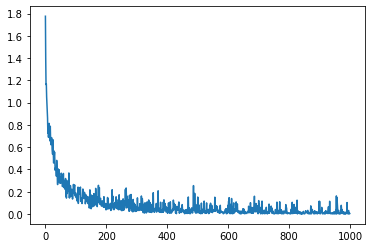

In [30]:
hidden_size = 100
model_type = 'lstm'
dropout_p = 0.1
attention = True
num_layers = 1
encoder1 = EncoderRNN(len(command2idx), hidden_size, dropout_p=dropout_p, model_type = model_type, num_layers = num_layers).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, len(action2idx), dropout_p=dropout_p, model_type = model_type, attention = attention, num_layers = num_layers).to(device)
trainIters(encoder1, attn_decoder1, 100000, print_every=5000)

## 3.3. Evaluate results

Testing on 14670 examples


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train  accuracy: 0.9916155419222904


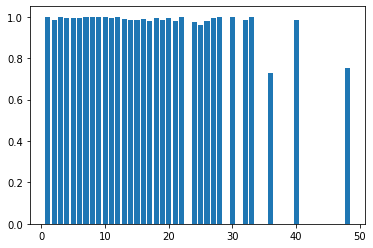

In [31]:
total = {}

counts = {}

print('Testing on ' + str(train_dataset.len) + ' examples')
for idx in range(train_dataset.len):
        l = len(train_dataset.actions[idx])
        output_words, attentions = evaluate(encoder1, attn_decoder1, train_dataset.__getitem__(idx)[0].long().to(device))
        output_sentence = to_sentence(output_words, idx2action)
        if(str(train_dataset.actions[idx]) == str(output_words)):
          total[l] = total[l] +1 if l in total else 1
        counts[l] = counts[l] +1 if l in counts else 1
a = pd.Series(total)
b = pd.Series(counts)
accuracy = a.sum()/b.sum()
print('Train  accuracy: ' + str(accuracy))
plt.bar(b.keys(), a/b)
plt.show()

Testing on 7706 examples


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Test accuracy with oracle: 0.004541915390604724


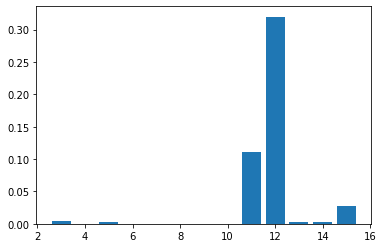

In [32]:
# Oracle test for experiment 2

total = {}

counts = {}

print('Testing on ' + str(test_dataset.len) + ' examples')
for idx in range(test_dataset.len):
        l = len(test_dataset.actions[idx])
        input, output = test_dataset.__getitem__(idx)
        output_words, attentions = evaluateOracle(encoder1, attn_decoder1, input.long().to(device), output.long().to(device))
        output_sentence = to_sentence(output_words, idx2action)
        if(str(test_dataset.actions[idx]) == str(output_words)):
          total[l] = total[l] +1 if l in total else 1
        counts[l] = counts[l] +1 if l in counts else 1
a = pd.Series(total)
b = pd.Series(counts)
accuracy = a.sum()/b.sum()
print('Test accuracy with oracle: ' + str(accuracy))
plt.bar(b.keys(), a/b)
plt.show()

Testing on 7706 examples


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Test accuracy: 0.0007786140669608098


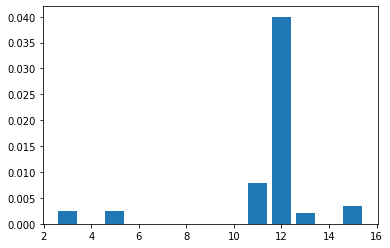

In [33]:
total = {}

counts = {}

print('Testing on ' + str(test_dataset.len) + ' examples')
for idx in range(test_dataset.len):
        l = len(test_dataset.actions[idx])
        output_words, attentions = evaluate(encoder1, attn_decoder1, test_dataset.__getitem__(idx)[0].long().to(device))
        output_sentence = to_sentence(output_words, idx2action)
        if(str(test_dataset.actions[idx]) == str(output_words)):
          total[l] = total[l] +1 if l in total else 1
        counts[l] = counts[l] +1 if l in counts else 1
a = pd.Series(total)
b = pd.Series(counts)
accuracy = a.sum()/b.sum()
print('Test accuracy: ' + str(accuracy))
plt.bar(b.keys(), a/b)
plt.show()

In [34]:
def visualize(idx, dataset):
    output_words, attentions = evaluate(encoder1, attn_decoder1, dataset.__getitem__(idx)[0].long().to(device))
    output_sentence = to_sentence(output_words, idx2action)
    print(output_words)
    print(attentions.shape)
    y = to_sentence(dataset.commands[idx], idx2command)+ ['<EOS>']
    x = output_sentence+ ['<EOS>']
    plt.matshow(attentions.numpy().T)
    plt.xticks(range(len(x)), x , fontsize=8, rotation=90)
    plt.yticks(range(len(y)), y , fontsize=12)
    plt.show()

[7, 8, 7, 4, 7, 8, 7, 8, 5, 3, 5, 3]
torch.Size([13, 8])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


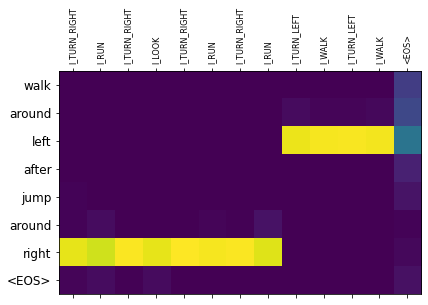

In [37]:
visualize(3000, test_dataset)

In [36]:
train_data.apply(lambda x: len(x['In']), axis = 1).describe()

count    14670.000000
mean         6.643763
std          2.208942
min          1.000000
25%          6.000000
50%          7.000000
75%          8.000000
max          9.000000
dtype: float64

# 4. Individual part: Transformer model on SCAN dataset


In [12]:
# Import packages for transformer
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_
from torch.autograd import Variable
from torch.nn import MultiheadAttention

# For plots
%matplotlib inline
import matplotlib.pyplot as plt

MAX_LENGTH = 48
CLIP = 5

In [13]:
#copied from http://nlp.seas.harvard.edu/2018/04/03/attention.html

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, dim_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, dim_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2) *
                             -(math.log(10000.0) / dim_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, dim_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(dim_model, d_ff)
        self.w_2 = nn.Linear(d_ff, dim_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

### 4.1. Encoder

In [14]:
# This code has been inspired  by:
# https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb and
# http://nlp.seas.harvard.edu/2018/04/03/attention.html

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class TransformerEncoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self,encoder_layer, num_layers):
        super(TransformerEncoder, self).__init__()
        self.norm = nn.LayerNorm(encoder_layer.hid_dim)
        self.layers = clones(encoder_layer, num_layers)

    def forward(self, src, mask=None):
        for layer in self.layers:
            src = layer(src, src_mask=mask)

        return self.norm(src)


class TransformerEncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pwff_dim=200, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.hid_dim = hid_dim

        # Self attention
        self.self_attn = MultiHeadAttentionLayer(hid_dim, n_heads, dropout=dropout, device=device)
        # Feedforward
        self.pwff = PositionwiseFeedForward(hid_dim,pwff_dim)
        # Normalization and dropout
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.pwff_layer_norm = nn.LayerNorm(hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src2, _ = self.self_attn(src, src, src, mask=src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(src2))
        src2 = self.pwff(src)
        src = self.pwff_layer_norm(src + self.dropout(src2))
        return src


### 4.2. Decoder

In [15]:
class TransformerDecoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, decoder_layer, num_layers):
        super(TransformerDecoder, self).__init__()

        self.norm = nn.LayerNorm(decoder_layer.hid_dim)
        self.layers = clones(decoder_layer, num_layers)


    def forward(self, trg, memory, trg_mask=None, memory_mask=None):
        attn_weights = []
        output = trg
        for layer in self.layers:
            output, attention = layer(output, memory, trg_mask=trg_mask, memory_mask=memory_mask)
            attn_weights.append(attention)

        output = self.norm(output)

        return output, attn_weights



class TransformerDecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pwff_dim=200, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.hid_dim = hid_dim

        # Self attention
        self.self_attn = MultiHeadAttentionLayer(hid_dim, n_heads, dropout=dropout,device=device)
        self.enc_attn = MultiHeadAttentionLayer(hid_dim, n_heads, dropout=dropout,device=device)

        # Feedforward
        self.pwff = PositionwiseFeedForward(hid_dim,pwff_dim,dropout)

        # Normalization
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, memory, trg_mask=None, memory_mask=None):
        trg2, _ = self.self_attn(trg, trg, trg, mask=trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(trg2))

        trg2, attn_weights = self.enc_attn(trg, memory, memory, mask=memory_mask) 
        trg = self.enc_attn_layer_norm(trg + self.dropout(trg2))

        trg2 = self.pwff(trg)
        trg = self.ff_layer_norm(trg + self.dropout(trg2))

        return trg, attn_weights

### 4.3. Attention

In [16]:
#copied from https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

 ## 4.4. Transformer model


In [17]:
class Transformer(nn.Module):
    def __init__(self,src_vocab_size,trg_vocab_size,hid_dim,n_heads,
                 n_layers, pwff_dim, dropout, pad_idx, device):
        super(Transformer,self).__init__()
        self.src_vocab_size = src_vocab_size
        self.trg_vocab_size = trg_vocab_size
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.pwff_dim  = pwff_dim 
        self.dropout = dropout
        self.pad_idx = pad_idx
        self.device = device

        # Initialize parameters
        self.initialize_parameters()

        # Input
        self.src_embedding = nn.Embedding(src_vocab_size,hid_dim)
        self.trg_embedding = nn.Embedding(trg_vocab_size,hid_dim)
        self.positional_encoding = PositionalEncoding(hid_dim,dropout)
        # Encoder
        encoder_layer = TransformerEncoderLayer(hid_dim, n_heads, pwff_dim, dropout)
        self.encoder = TransformerEncoder(encoder_layer, n_layers)

        # Decoder
        decoder_layer = TransformerDecoderLayer(hid_dim, n_heads, pwff_dim, dropout)        
        self.decoder = TransformerDecoder(decoder_layer, n_layers)

        # Output
        self.linear = nn.Linear(hid_dim,trg_vocab_size)

    def forward(self,src,trg):
        # Masks
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        # Input
        src = self.src_embedding(src)
        src = self.positional_encoding(src)
        trg = self.trg_embedding(trg)
        trg = self.positional_encoding(trg)
        # Encoder
        memory = self.encoder(src, mask=src_mask)
        # Decoder
        out, attn_weights = self.decoder(trg, memory, trg_mask=trg_mask,
                                         memory_mask=src_mask)
        # Output
        out = self.linear(out)

        return out, attn_weights

    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]        
        trg_pad_mask = (trg != self.pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def initialize_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

## 4.5. Train transformer

In [18]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remaining - %s)' % (asMinutes(s), asMinutes(rs))

In [19]:
def train_transformer(model, n_iters = 50000, report_iter_every = 2000, test_every = len(train_loader), plot_every = 100, clip=CLIP):
    model.train()

    # Loss function
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), learning_rate)

    # Setup things to record
    loss_data = [] # records losses
    test_accs = [] # records test accuracy
    print_loss_total = 0
    plot_loss_total = 0
    start = time.time()

    # Training loop:

    for i in range(1,n_iters+1):
        training_pair = next(iter(train_loader))
        input_tensor = training_pair[0].view(1,-1).long().to(device)
        target_tensor = training_pair[1].view(1,-1).long().to(device)
        optimizer.zero_grad()
        out, _ = model(input_tensor,target_tensor)
        loss = criterion(out.view(-1,trg_vocab_size),target_tensor.view(-1))
        print_loss_total += loss
        plot_loss_total += loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # Record loss
        if i > 0 and i % report_iter_every == 0:
            loss_datapoint = loss.data.item()
            print_loss_avg = print_loss_total / report_iter_every
            print_loss_total = 0
            print('Epoch:', int(i / len(train_loader)),
                  ', Iter: %d (%d%%)' % ( i,  i / n_iters * 100), '\n', 
                  'Avg. Loss: %.4f' % (print_loss_avg),'\n', 
                  'Elapsed Time: %s' % timeSince(start, i / n_iters),'\n', 
                  '='*50)

            loss_data.append(loss_datapoint)

        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            loss_data.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(loss_data)


    # Checkpoint
    if i % test_every == 0:
        # Checkpoint on test data
        print("Checking test accuracy...")
        test_acc = test(test_loader, model, pad_idx, device)
        print("Test accuracy is ", test_acc)
        test_accs.append(test_acc)


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [20]:
# Function for testing models - based on https://github.com/jlrussin/transformer_scan/blob/master/test.py

def accuracy(data, model, pad_idx, device):
    model.eval()
    with torch.no_grad():
        all_correct_trials = [] # list of booleans indicating whether correct
        for batch in data:
            input_tensor = batch[0].view(1,-1).long().to(device)
            target_tensor = batch[1].view(1,-1).long().to(device)

            out, _ = model(input_tensor,target_tensor)
            preds = torch.argmax(out,dim=2)
            correct_pred = preds == target_tensor
            correct_pred = correct_pred.cpu().numpy()
            mask = target_tensor == pad_idx # mask out padding
            mask = mask.cpu().numpy()
            correct = np.logical_or(mask,correct_pred)
            correct = correct.all(0).tolist()
            all_correct_trials += correct

    accuracy = np.mean(all_correct_trials)
    model.train()
    return accuracy

## 4.6. Run Transformer

The model has 2,261,010 trainable parameters
Epoch: 0 , Iter: 500 (10%) 
 Avg. Loss: 0.0558 
 Elapsed Time: 0m 19s (remaining - 2m 55s) 
Epoch: 0 , Iter: 1000 (20%) 
 Avg. Loss: 0.0004 
 Elapsed Time: 0m 38s (remaining - 2m 35s) 
Epoch: 0 , Iter: 1500 (30%) 
 Avg. Loss: 0.0002 
 Elapsed Time: 0m 58s (remaining - 2m 15s) 
Epoch: 0 , Iter: 2000 (40%) 
 Avg. Loss: 0.0001 
 Elapsed Time: 1m 17s (remaining - 1m 56s) 
Epoch: 0 , Iter: 2500 (50%) 
 Avg. Loss: 0.0001 
 Elapsed Time: 1m 37s (remaining - 1m 37s) 
Epoch: 0 , Iter: 3000 (60%) 
 Avg. Loss: 0.0000 
 Elapsed Time: 1m 56s (remaining - 1m 17s) 
Epoch: 0 , Iter: 3500 (70%) 
 Avg. Loss: 0.0000 
 Elapsed Time: 2m 15s (remaining - 0m 58s) 
Epoch: 0 , Iter: 4000 (80%) 
 Avg. Loss: 0.0000 
 Elapsed Time: 2m 34s (remaining - 0m 38s) 
Epoch: 0 , Iter: 4500 (90%) 
 Avg. Loss: 0.0000 
 Elapsed Time: 2m 54s (remaining - 0m 19s) 
Epoch: 0 , Iter: 5000 (100%) 
 Avg. Loss: 0.0000 
 Elapsed Time: 3m 13s (remaining - 0m 0s) 


<Figure size 432x288 with 0 Axes>

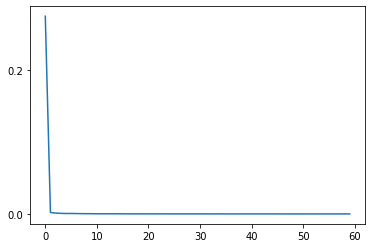

In [21]:
n_iters = 5000
report_iter_every = 500
d_model = 200
nhead = 4
num_layers = 2
dim_feedforward = 800
dropout = 0.1
learning_rate = 0.001
device = 'cpu' # works faster

# vocab
src_vocab_size = len(SRC.vocab.stoi)
trg_vocab_size = len(TRG.vocab.stoi)
pad_idx = SRC.vocab.stoi[PAD_TOKEN]

model = Transformer(src_vocab_size,trg_vocab_size,d_model, nhead, num_layers,
                    dim_feedforward, dropout,pad_idx,device).to(device)

print(f'The model has {count_parameters(model):,} trainable parameters')
train_transformer(model, n_iters=n_iters,report_iter_every=report_iter_every)

## 4.7. Evaluate transformer performace

In [22]:
# Checkpoint on test data
print("Checking test accuracy...")
test_acc = accuracy(test_loader, model, pad_idx, device)
print("Test accuracy is ", test_acc)

Checking test accuracy...
Test accuracy is  1.0


In [23]:
# "translate" n random commands from dataset into actions
def translate_commands(model, idx, ds = test_dataset, n=3):
    model.eval()
    #idx = random.randint(0,len(ds))
    print('Showing entry number: ', idx)
    input_sentence = to_sentence(ds.commands[idx],idx2command)
    print('>', input_sentence)
    print('=', to_sentence(ds.actions[idx], idx2action))
    input_tensor = ds.__getitem__(idx)[0].long().view(1,-1).to(device)
    #print(input_tensor.shape)
    target_tensor = ds.__getitem__(idx)[1].long().view(1,-1).to(device)
    out, attention = model(input_tensor,target_tensor)
    preds = torch.argmax(out,dim=2)
    #print(preds)
    preds = preds.squeeze(dim =1).tolist()
    translation = to_sentence(preds[0][:-1], idx2action)
    
    #print(preds)
    print('<',translation)
    return input_sentence,translation, attention
    #print('<', to_sentence(preds[0][:-1], idx2action))  #[:-1] removes EOS tag
    #return to_sentence(preds, idx2action)


In [24]:
def visualize_attention(model, idx, layer = 'encoder', n_heads = 4, n_rows = 2, n_cols = 2):
    
    assert n_rows * n_cols == n_heads

    sentence,translation, attention = translate_commands(model,idx)
    attention = attention[0] if layer =='encoder' else attention[1]

    fig = plt.figure(figsize=(15,10))  

    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].detach().numpy().T

        ax.matshow(_attention)
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+translation+['<eos>'],rotation=90,fontsize=12)
        ax.set_yticklabels(['']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45,fontsize=15)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.tight_layout()
    plt.show()


Showing entry number:  3000
> ['walk', 'around', 'left', 'after', 'jump', 'around', 'right']
= ['I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK']
< ['I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK']


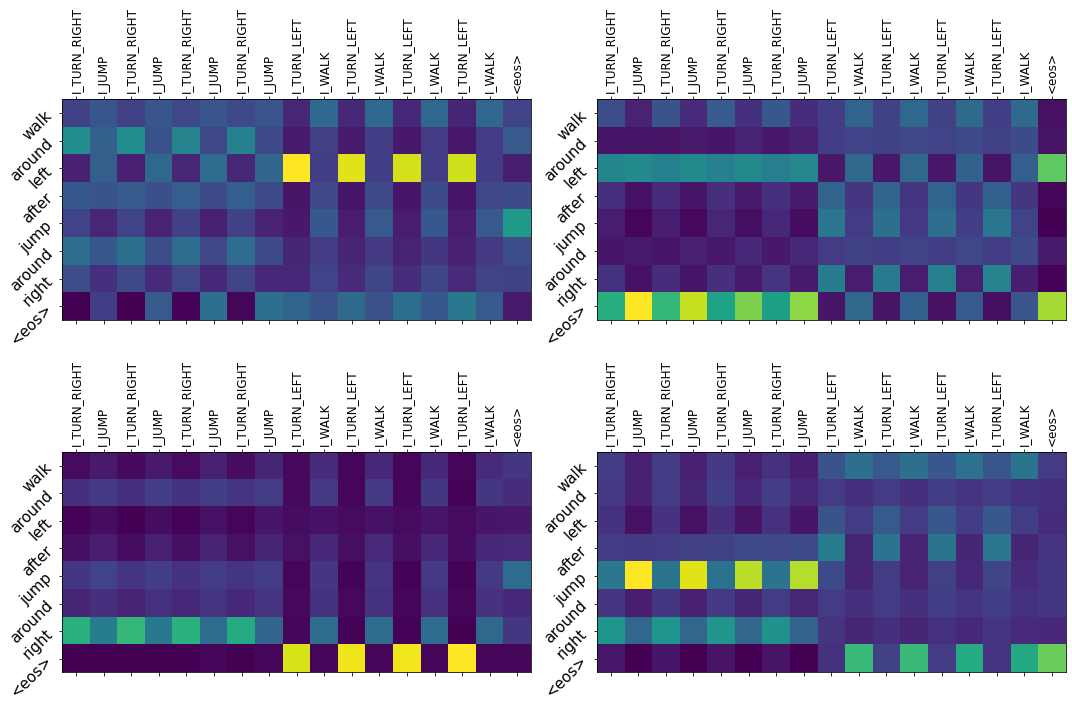

In [25]:
visualize_attention(model, 3000)

# 5. Appendix: Different transformer implementation

This work is largely based on https://github.com/jlrussin/transformer_scan.
It is adjusted to fit the dataloader that we implemented in the group. But since it was built for the same task that I tried to solve, it only serves as a benchmark for the performance of the model implemented in the previous section.

In [37]:
# Transformer model
# This code has been repurposed from:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html

import math
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_



class TransformerEncoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self,encoder_layer, num_layers):
        super(TransformerEncoder, self).__init__()
        self.norm = nn.LayerNorm(encoder_layer.dim_model)
        self.layers = clones(encoder_layer, num_layers)

    def forward(self, src, mask=None, src_kp_mask=None):
        attn_weights = []
        output = src
        for mod in self.layers:
            output, attn_wts = mod(output, src_mask=mask,
                                   src_kp_mask=src_kp_mask)
            attn_weights.append(attn_wts)

        output = self.norm(output)

        return output, attn_weights


class TransformerDecoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, decoder_layer, num_layers):
        super(TransformerDecoder, self).__init__()

        self.norm = nn.LayerNorm(decoder_layer.dim_model)
        self.layers = clones(decoder_layer, num_layers)

    def forward(self, trg, memory, trg_mask=None, memory_mask=None,
                trg_kp_mask=None, memory_kp_mask=None):
        attn_weights = []
        output = trg
        for mod in self.layers:
            output, attn_wts = mod(output, memory, trg_mask=trg_mask,
                memory_mask=memory_mask,
                trg_kp_mask=trg_kp_mask,
                memory_kp_mask=memory_kp_mask)
            attn_weights.append(attn_wts)
            
        output = self.norm(output)

        return output, attn_weights


class TransformerEncoderLayer(nn.Module):
    def __init__(self, dim_model, nhead, dim_feedforward=200, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.dim_model = dim_model
        self.nhead = nhead
        self.dim_feedforward = dim_feedforward

        # Self attention
        self.self_attn = nn.MultiheadAttention(dim_model, nhead, dropout=dropout)
        # Feedforward
        self.pwff = PositionwiseFeedForward(dim_model,dim_feedforward)
        # Normalization
        self.norm1 = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)


    def forward(self, src, src_mask=None, src_kp_mask=None):
        src2, attn_weights = self.self_attn(src, src, src, attn_mask=src_mask,
                                key_padding_mask=src_kp_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.pwff(src)
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src, attn_weights


class TransformerDecoderLayer(nn.Module):
    def __init__(self, dim_model, nhead, dim_feedforward=200, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.dim_model = dim_model
        self.nhead = nhead
        self.dim_feedforward = dim_feedforward

        # Self attention
        self.self_attn = nn.MultiheadAttention(dim_model, nhead,
                                               dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(dim_model, nhead,
                                                    dropout=dropout)
        # Feedforward
        self.pwff = PositionwiseFeedForward(dim_model,dim_feedforward)
        # Normalization
        self.norm1 = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        self.norm3 = nn.LayerNorm(dim_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)


    def forward(self, trg, memory, trg_mask=None, memory_mask=None,
                trg_kp_mask=None, memory_kp_mask=None):
        trg2, attn_weights1 = self.self_attn(trg, trg, trg, attn_mask=trg_mask,
                                        key_padding_mask=trg_kp_mask)
        trg = trg + self.dropout1(trg2)
        trg = self.norm1(trg)
        trg2, attn_weights2 = self.multihead_attn(trg, memory, memory,
                                        attn_mask=memory_mask,
                                        key_padding_mask=memory_kp_mask)
        trg = trg + self.dropout2(trg2)
        trg = self.norm2(trg)
        trg2 = self.pwff(trg)
        trg = trg + self.dropout3(trg2)
        trg = self.norm3(trg)

        attn_weights = {'Sublayer1' : attn_weights1,
                        'Sublayer2' : attn_weights2}
        return trg, attn_weights


def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


In [38]:
class Transformer(nn.Module):
    def __init__(self,src_vocab_size,trg_vocab_size,d_model,nhead,
                 num_layers, dim_feedforward,dropout,pad_idx,device):
        super(Transformer,self).__init__()
        self.src_vocab_size = src_vocab_size
        self.trg_vocab_size = trg_vocab_size
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.pad_idx = pad_idx
        self.device = device

        # Input
        self.src_embedding = nn.Embedding(src_vocab_size,d_model)
        self.trg_embedding = nn.Embedding(trg_vocab_size,d_model)
        self.positional_encoding = PositionalEncoding(d_model,dropout)
        # Encoder
        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward,
                                                dropout)

        self.encoder = TransformerEncoder(encoder_layer, num_layers)
        # Decoder
        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward,
                                                dropout)
        
        self.decoder = TransformerDecoder(decoder_layer, num_layers)
        # Output
        self.linear = nn.Linear(d_model,trg_vocab_size)
        # Initialize
        self._reset_parameters()

    def forward(self,src,trg):
        # Masks
        src_mask = None
        trg_mask,src_kp_mask,trg_kp_mask = self._get_masks(src,trg)
        # Input
        src = self.src_embedding(src)
        src = self.positional_encoding(src)
        trg = self.trg_embedding(trg)
        trg = self.positional_encoding(trg)
        # Encoder
        memory, enc_attn_wts = self.encoder(src, mask=src_mask,
                                            src_kp_mask=src_kp_mask)
        # Decoder
        memory_mask = None
        memory_kp_mask = None
        out, dec_attn_wts = self.decoder(trg, memory, trg_mask=trg_mask,
                                         memory_mask=memory_mask,
                                         trg_kp_mask=trg_kp_mask,
                                         memory_kp_mask=memory_kp_mask)
        # Output
        out = self.linear(out)
        # Attention weights
        attn_wts = {'Encoder':enc_attn_wts,
                    'Decoder':dec_attn_wts}
        return out, attn_wts

    def _get_masks(self,src,trg):
        sz = trg.shape[0]
        trg_mask = self._generate_square_subsequent_mask(sz)
        trg_mask = trg_mask.to(self.device)
        src_kp_mask = (src == self.pad_idx).transpose(0,1).to(self.device)
        trg_kp_mask = (trg == self.pad_idx).transpose(0,1).to(self.device)
        return trg_mask,src_kp_mask,trg_kp_mask

    def _generate_square_subsequent_mask(self,sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf'))
        mask = mask.masked_fill(mask == 1, float(0.0))
        return mask

    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

## 5.1. Train transformer

In [39]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remaining - %s)' % (asMinutes(s), asMinutes(rs))

In [40]:
def train_transformer(model, n_iters = 50000, report_iter_every = 2000, test_every = len(train_loader), plot_every = 200,clip=CLIP):
    model.train()
    # Loss function
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), learning_rate)

    # Setup things to record
    loss_data = [] # records losses
    test_accs = [] # records test accuracy
    print_loss_total = 0
    plot_loss_total = 0
    start = time.time()

    # Training loop:

    for i in range(1,n_iters+1):
        training_pair = next(iter(train_loader))
        input_tensor = training_pair[0].view(-1,1).long().to(device)
        target_tensor = training_pair[1].view(-1,1).long().to(device)
        optimizer.zero_grad()
        out, _ = model(input_tensor,target_tensor)
        loss = criterion(out.view(-1,trg_vocab_size),target_tensor.view(-1))
        print_loss_total += loss
        plot_loss_total += loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        # Record loss
        if i > 0 and i % report_iter_every == 0:
            loss_datapoint = loss.data.item()
            print_loss_avg = print_loss_total / report_iter_every
            print_loss_total = 0
            print('Epoch:', int(i / len(train_loader)),
                  ', Iter: %d (%d%%)' % ( i,  i / n_iters * 100), '\n', 
                  'Avg. Loss: %.4f' % (print_loss_avg),'\n', 
                  'Elapsed Time: %s' % timeSince(start, i / n_iters),'\n', 
                  '='*50)

            loss_data.append(loss_datapoint)

        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            loss_data.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(loss_data)


    # Checkpoint
    if i % test_every == 0:
        # Checkpoint on test data
        print("Checking test accuracy...")
        test_acc = test(test_loader, model, pad_idx, device)
        print("Test accuracy is ", test_acc)
        test_accs.append(test_acc)


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


In [41]:
# Function for testing models
import numpy as np
import torch

def test(data, model, pad_idx, device):
    model.eval()
    print("Checking test accuracy...")
    with torch.no_grad():
        all_correct_trials = [] # list of booleans indicating whether correct
        for batch in data:
            out, _ = model.forward(batch[0].view(-1,1).long().to(device),batch[1].view(-1,1).long().to(device))
            preds = torch.argmax(out,dim=2)
            correct_pred = preds == batch[1].view(-1,1).long().to(device)
            correct_pred = correct_pred.cpu().numpy()
            mask = batch[1].view(-1,1).long().to(device) == pad_idx # mask out padding
            mask = mask.cpu().numpy()
            correct = np.logical_or(mask,correct_pred)
            correct = correct.all(0).tolist()
            all_correct_trials += correct

    accuracy = np.mean(all_correct_trials)
    model.train()
    return accuracy

Epoch: 0 , Iter: 500 (10%) 
 Avg. Loss: 1.6178 
 Elapsed Time: 0m 15s (remaining - 2m 18s) 
Epoch: 0 , Iter: 1000 (20%) 
 Avg. Loss: 0.1862 
 Elapsed Time: 0m 31s (remaining - 2m 4s) 
Epoch: 0 , Iter: 1500 (30%) 
 Avg. Loss: 0.0734 
 Elapsed Time: 0m 47s (remaining - 1m 50s) 
Epoch: 0 , Iter: 2000 (40%) 
 Avg. Loss: 0.0436 
 Elapsed Time: 1m 3s (remaining - 1m 35s) 
Epoch: 0 , Iter: 2500 (50%) 
 Avg. Loss: 0.0433 
 Elapsed Time: 1m 19s (remaining - 1m 19s) 
Epoch: 0 , Iter: 3000 (60%) 
 Avg. Loss: 0.0396 
 Elapsed Time: 1m 36s (remaining - 1m 4s) 
Epoch: 0 , Iter: 3500 (70%) 
 Avg. Loss: 0.0269 
 Elapsed Time: 1m 52s (remaining - 0m 48s) 
Epoch: 0 , Iter: 4000 (80%) 
 Avg. Loss: 0.0253 
 Elapsed Time: 2m 9s (remaining - 0m 32s) 
Epoch: 0 , Iter: 4500 (90%) 
 Avg. Loss: 0.0415 
 Elapsed Time: 2m 25s (remaining - 0m 16s) 
Epoch: 0 , Iter: 5000 (100%) 
 Avg. Loss: 0.0481 
 Elapsed Time: 2m 40s (remaining - 0m 0s) 


<Figure size 432x288 with 0 Axes>

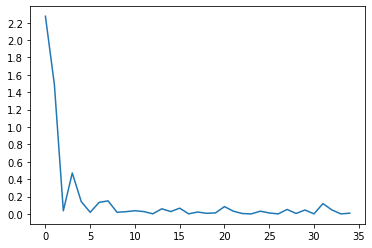

In [42]:
n_iters = 5000
report_iter_every = 500
d_model = 200
nhead = 4
num_layers = 2
dim_feedforward = 800
dropout = 0.1
learning_rate = 0.001
device = 'cpu' # works faster

# vocab
src_vocab_size = len(SRC.vocab.stoi)
trg_vocab_size = len(TRG.vocab.stoi)
pad_idx = SRC.vocab.stoi[PAD_TOKEN]

# Model ((self, size, n_heads, self_attn, src_attn, feed_forward, dropout):
model = Transformer(src_vocab_size,trg_vocab_size,d_model, nhead, num_layers,
                    dim_feedforward, dropout,pad_idx,device).to(device)

#model2 = make_model(src_vocab_size,trg_vocab_size)
train_transformer(model, n_iters=n_iters,report_iter_every=report_iter_every)

In [43]:
# Checkpoint on test data
test_acc = test(test_loader, model, pad_idx, device)
print("Test accuracy is ", test_acc)

Checking test accuracy...
Test accuracy is  0.35725408772385153


In [44]:
# "translate" n random commands from dataset into actions
def translate_commands(model, ds = test_dataset, n=3):
    model.eval()
    for i in range(n):
      idx = random.randint(0,len(ds))
      print(idx)
      print('>', to_sentence(ds.commands[idx],idx2command))
      print('=', to_sentence(ds.actions[idx], idx2action))
      out, attn_wts = model(ds.__getitem__(idx)[0].long().to(device),ds.__getitem__(idx)[1].long().to(device))
      preds = torch.argmax(out,dim=2)
      preds = preds.squeeze(dim =1).tolist()[:-1] # we need to remove the last element in the list
      print('<', to_sentence(preds, idx2action))
      #return to_sentence(preds, idx2action)


In [45]:
trans = translate_commands(model)

4287
> ['turn', 'opposite', 'right', 'after', 'jump', 'opposite', 'right', 'twice']
= ['I_TURN_RIGHT', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_TURN_RIGHT']
< ['I_TURN_RIGHT', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_TURN_RIGHT']
3217
> ['walk', 'around', 'right', 'and', 'jump', 'left']
= ['I_TURN_RIGHT', 'I_WALK', 'I_TURN_RIGHT', 'I_WALK', 'I_TURN_RIGHT', 'I_WALK', 'I_TURN_RIGHT', 'I_WALK', 'I_TURN_LEFT', 'I_JUMP']
< ['I_TURN_RIGHT', 'I_WALK', 'I_TURN_RIGHT', 'I_WALK', 'I_TURN_RIGHT', 'I_WALK', 'I_TURN_RIGHT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK']
6999
> ['jump', 'around', 'left', 'and', 'walk', 'opposite', 'left']
= ['I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_WALK']
< ['I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_TUR